# Data analysis on ctftime

## imports

In [1]:
import json
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup

CTFTIME_HEADERS = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}

BASE_URL = "https://ctftime.org"
EVENT_URL = f"{BASE_URL}/event"
STATS_URL = f"{BASE_URL}/stats"
API_URL = f"{BASE_URL}/api/v1"

---
## Scrap data

In [2]:
def getCountryMap():
    r = requests.get(f"{STATS_URL}/US", headers=CTFTIME_HEADERS)
    soup = BeautifulSoup(r.text, 'lxml')
    countries = soup.find_all('ul', {"class": "dropdown-menu"})[3].find_all('li')[1:]
    maper = lambda x: (x.a.attrs['href'].split("/")[-1], x.text)
    return dict(map(maper, countries)) | {"idk":"idk"}


def parsePage(team):
    tds = team.find_all('td')
    rank = tds[0].text
    team_name = tds[2].text
    team_id = tds[2].a.attrs['href'].split("/")[-1]
    if tds[3].img:
        country = tds[3].img.attrs['alt']
    else:
        country = "idk"
    score = tds[4].text
    events = tds[5].text
    return rank, team_name, team_id, country, score, events


def getTeamInfo(YEAR, page=15):
    for i in range(page):
        r = requests.get(f"{STATS_URL}/{YEAR}?page={i+1}", headers=CTFTIME_HEADERS)
        soup = BeautifulSoup(r.text, 'lxml')
        for team in soup.find_all('tr')[1:51]:
            yield parsePage(team)

def saveRank(YEAR, csvFile):
    df = pd.DataFrame(columns=['rank', 'Name', 'team_id', 'country','score', 'events'])
    for i, data in enumerate(getTeamInfo(YEAR)):
        df.loc[i] = data
    convert_dict = {'rank': int, 'team_id':int, 'score': float, 'events':int}
    df = df.astype(convert_dict)
    df.to_csv(csvFile, index=False)
    return df

---
## Load data by year

In [3]:
YEAR = 2024

csvFile = f"data/CTFTIME_{YEAR}.csv"
if os.path.isfile(csvFile):
    ctftime_df = pd.read_csv(csvFile)
else:
    ctftime_df = saveRank(YEAR, csvFile)

topN = ctftime_df[:200].copy()

---
## df_Show function

In [4]:
def df_Show( df, n=40 ):
    print( 'Dataset shape = ', df.shape)
    print("-"*n)
    display( df.loc[0] )
    print("-"*n)
    display( df.info(verbose=True) )
    print("-"*n)
    display( df.describe(include='all') )

In [5]:
df_Show(topN)

Dataset shape =  (200, 6)
----------------------------------------


rank                   1
Name       kalmarunionen
team_id           114856
country          Denmark
score           1721.038
events                49
Name: 0, dtype: object

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rank     200 non-null    int64  
 1   Name     200 non-null    object 
 2   team_id  200 non-null    int64  
 3   country  200 non-null    object 
 4   score    200 non-null    float64
 5   events   200 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 9.5+ KB


None

----------------------------------------


,rank,Name,team_id,country,score,events
count,200.000000,200,200.000000,200,200.000000,200.000000
unique,NaN,200,NaN,49,NaN,NaN
top,NaN,kalmarunionen,NaN,United States,NaN,NaN
freq,NaN,1,NaN,24,NaN,NaN
mean,100.500000,NaN,138384.600000,NaN,379.257915,28.365000
std,57.879185,NaN,100556.784652,NaN,213.696732,21.580323
min,1.000000,NaN,284.000000,NaN,191.834000,1.000000
25%,50.750000,NaN,41270.750000,NaN,231.370750,14.000000
50%,100.500000,NaN,141517.000000,NaN,318.365000,23.000000
75%,150.250000,NaN,221579.000000,NaN,424.080500,36.250000


---
### Scatter Matrix with KDE Plot

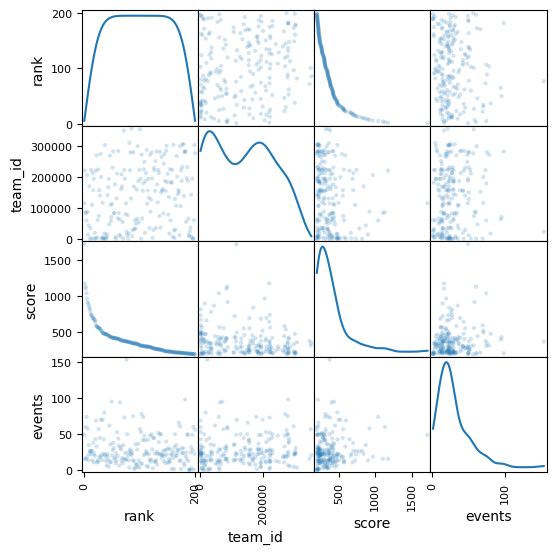

In [6]:
pd.plotting.scatter_matrix(topN, alpha=0.2, figsize=(6, 6), diagonal="kde")
plt.show()

---
### area plot on score

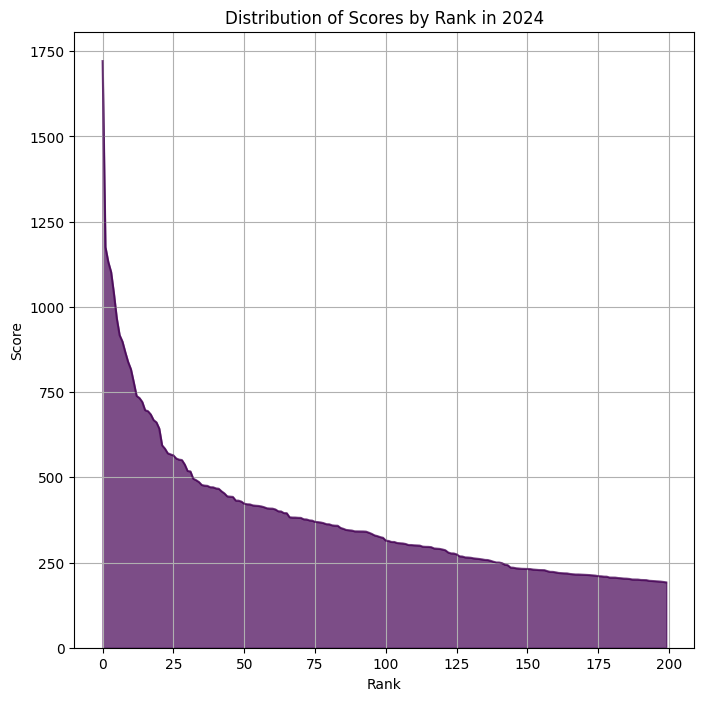

In [7]:
topN['score'].plot(
    title=f"Distribution of Scores by Rank in {YEAR}",
    kind='area',
    figsize=(8, 8),
    xlabel='Rank',
    ylabel='Score',
    colormap='viridis',
    alpha=0.7
)

plt.grid(True)
plt.show()

---
### histogram plot on events

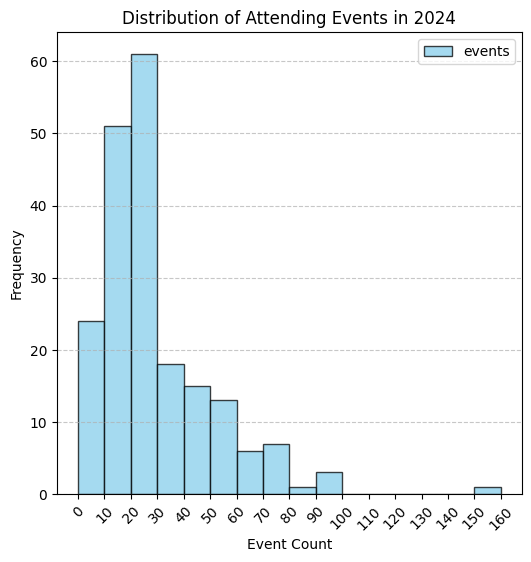

In [8]:
bins = list(range(0, 170, 10))
topN['events'].plot(
    kind='hist', 
    bins=bins, 
    figsize=(6, 6), 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.75, 
    legend=True, 
    title=f'Distribution of Attending Events in {YEAR}'
)

plt.xlabel('Event Count')
plt.ylabel('Frequency')
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
### boxplot for events

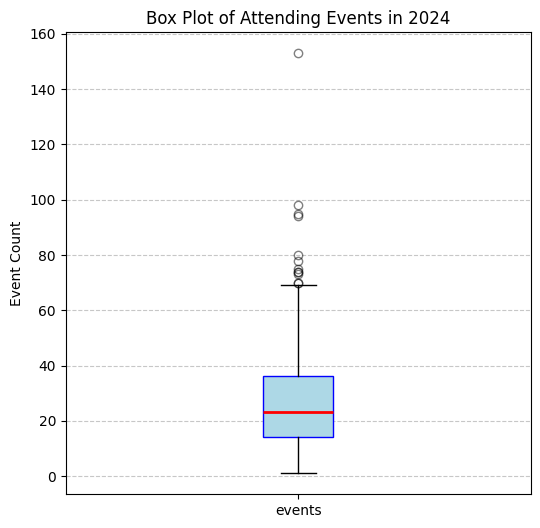

In [9]:
topN['events'].plot(
    kind='box', 
    figsize=(6, 6),
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    capprops=dict(color='black', linewidth=1),
    flierprops=dict(marker='o', color='red', alpha=0.5)
)

plt.title(f'Box Plot of Attending Events in {YEAR}')
plt.ylabel('Event Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
### scatter plot on score / events

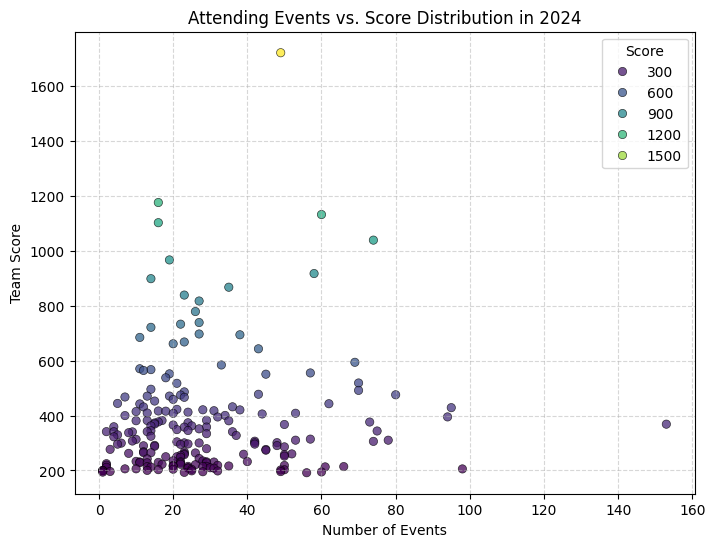

In [10]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x="events", 
    y="score", 
    data=topN, 
    hue="score", 
#     size="score", 
    palette="viridis",
    sizes=(20, 200),
    alpha=0.75,
    edgecolor="black"
)

plt.title(f"Attending Events vs. Score Distribution in {YEAR}")
plt.xlabel("Number of Events")
plt.ylabel("Team Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Score", loc="upper right")

plt.show()

---
### hexbin plot on score / events

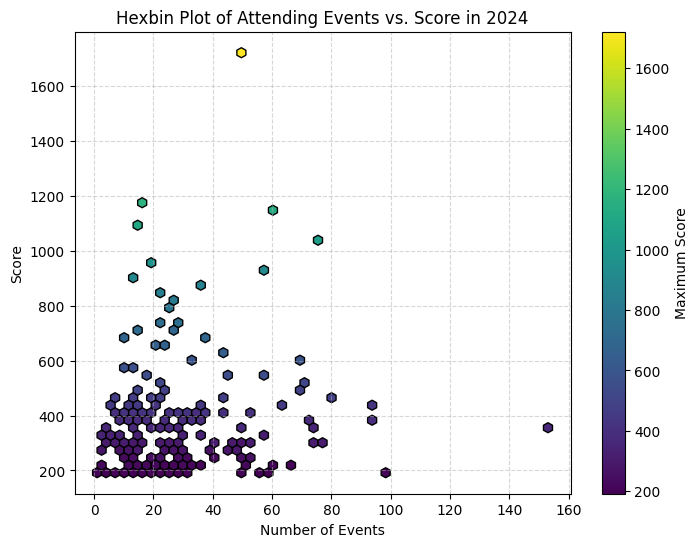

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
hb = ax.hexbin(
    topN["events"], 
    topN["score"], 
    C=topN["score"], 
    reduce_C_function=np.max, 
    gridsize=50, 
    cmap="viridis", 
    edgecolors="black", 
    mincnt=1
)

plt.title(f"Hexbin Plot of Attending Events vs. Score in {YEAR}")
plt.xlabel("Number of Events")
plt.ylabel("Score")
cb = fig.colorbar(hb, ax=ax, label="Maximum Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

---
### barh plot on country

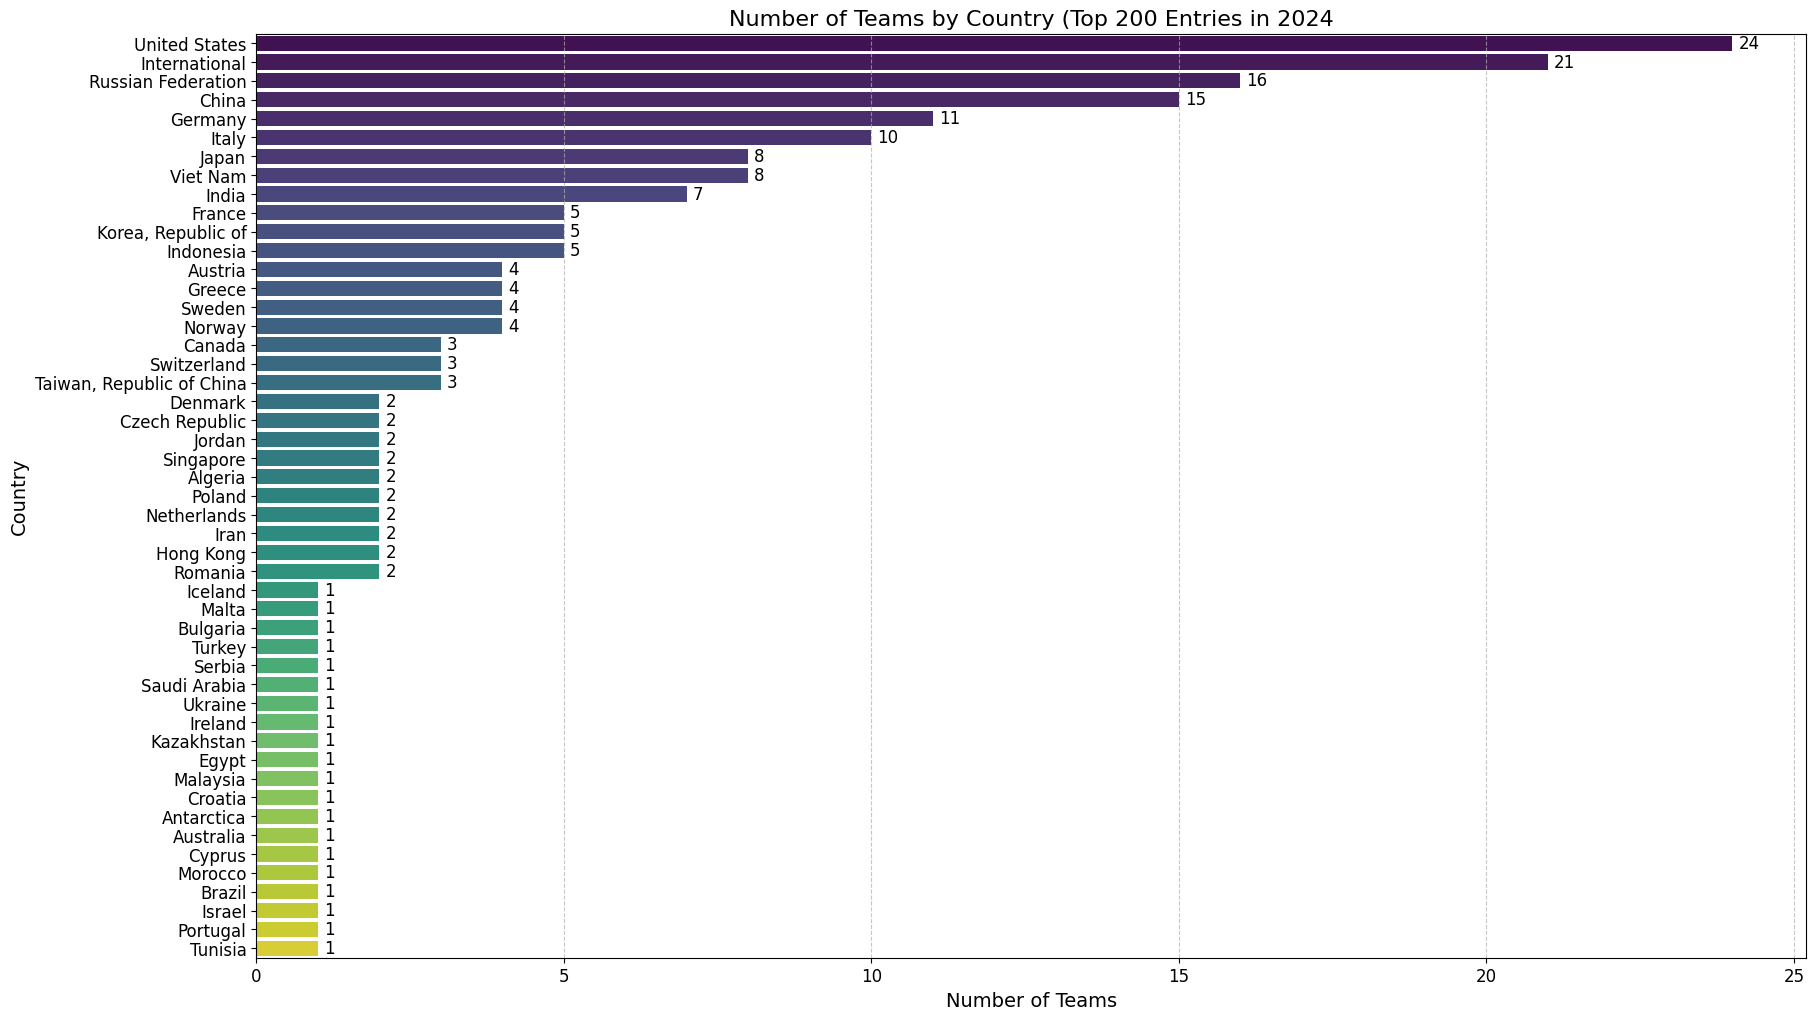

In [12]:
topN['country'] = topN['country'].replace('idk', 'International').replace('Iran, Islamic Republic of', 'Iran')

freq = topN['country'].value_counts().sort_values(ascending=True)[::-1]

plt.figure(figsize=(20, 12))
ax = sns.barplot(
    x=freq.values, 
    y=freq.index, 
    hue=freq.index, 
    palette="viridis"
)
for i, v in enumerate(freq.values):
    ax.text(v + 0.1, i, str(v), color='black', va='center', fontsize=12)

plt.title(f"Number of Teams by Country (Top 200 Entries in {YEAR}", fontsize=16)
plt.xlabel("Number of Teams", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

---
### update country name

In [13]:
def get_flag_emoji(country_id: str) -> str:
    code_point_start = ord("🇦") - ord("A")
    assert code_point_start == 127397
    code_points = [code_point_start + ord(char) for char in country_id]
    return "".join(chr(cp) for cp in code_points)

with open('data/countries.json') as f:
    countriesJson = json.load(f)
countriesJson['IR'] = 'Iran'
countriesJson['idk'] = 'International'

---
# Top N countries by team count

In [14]:
if os.path.exists('teams.csv'):
    teams_df = pd.read_csv('teams.csv')
else:
    teams_df = pd.DataFrame()

offset, limit = 0 if teams_df.empty else len(teams_df) - 200, 300

res = []
while True:
    result = requests.get(f'{API_URL}/teams/?{limit=}&{offset=}', headers=CTFTIME_HEADERS).json()['result']
    if not result:
        break
    res.extend(result)
    offset += 300

teams_df = pd.concat([teams_df, pd.DataFrame(res)]).drop_duplicates(subset=['id'], keep='first').reset_index(drop=True)

teams_df.replace({"country": countriesJson}, inplace=True)

teams_df.to_csv('teams.csv', index=False)

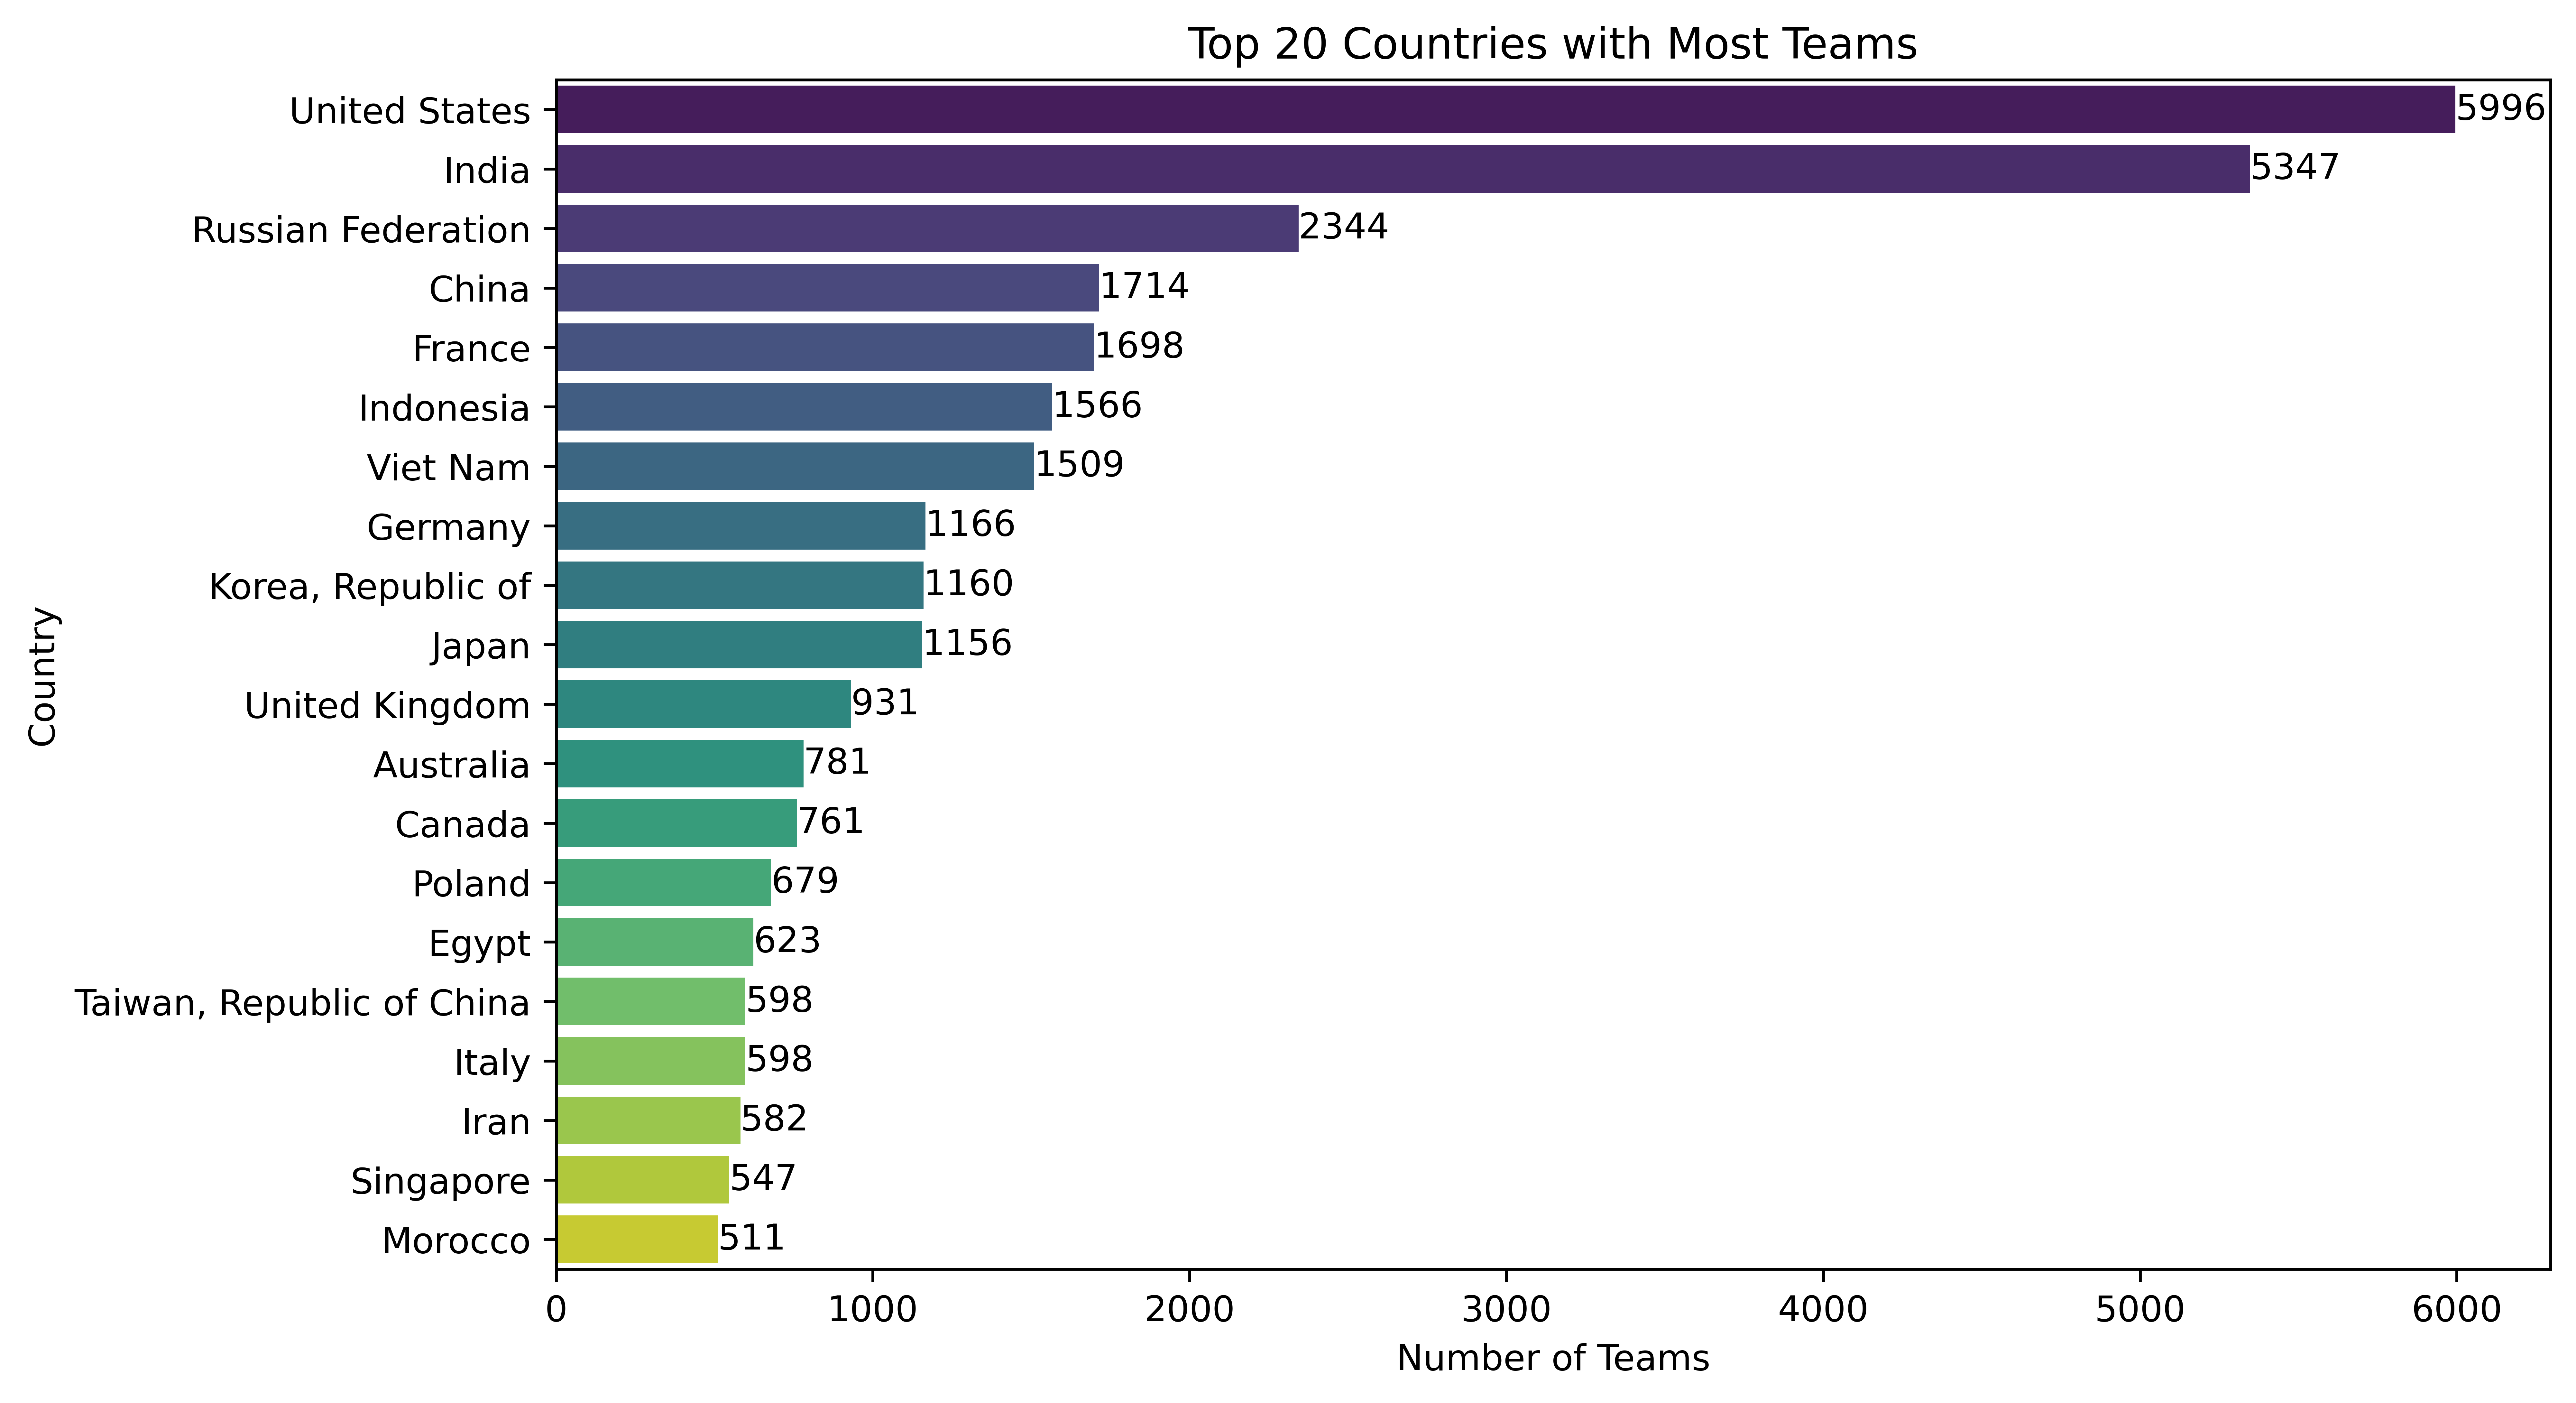

In [15]:
N = 20

top_countries = teams_df[teams_df['country'] != '']['country'].value_counts().head(N)

plt.figure(figsize=(10, 6), dpi=800)
ax = sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis', orient='h', hue=top_countries.index)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.xlabel('Number of Teams')
plt.ylabel('Country')
plt.title(f'Top {N} Countries with Most Teams')
plt.show()

---
# Top k Events by Points Earned at nth Place

In [16]:
def calcRate(team_place, team_point, best_point, total_teams, weight):
    point_coef = team_point / best_point
    place_coef = 1 / team_place
    rate = ( (point_coef+place_coef)*weight )
    rate /= (1 + team_place//total_teams)
    return float(f"{rate:.3f}")

In [17]:
res = requests.get(f'{API_URL}/results/{YEAR}/', headers=CTFTIME_HEADERS).json()
print(f'Total Events in {YEAR} = {len(res)}')

for key in res.keys():
    res[key]['weight'] = requests.get(f'{API_URL}/events/{key}/', headers=CTFTIME_HEADERS).json()['weight']

Total Events in 2024 = 255


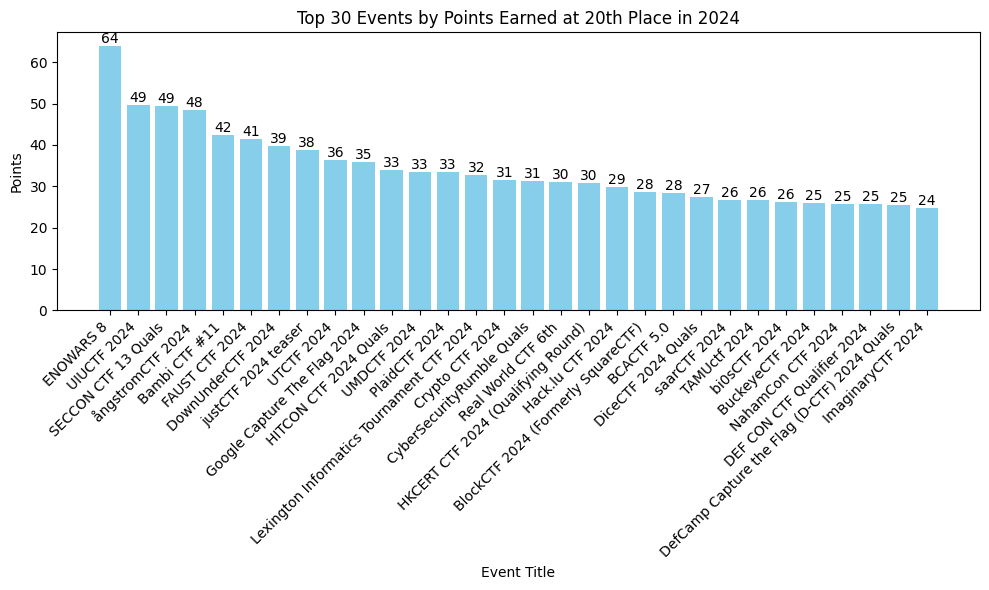

In [18]:
k = 30
rank = 20

item = 0
Organizer = pd.DataFrame(columns=['eventID', 'title', 'point'])
for key, value in res.items():
    if len(value['scores']) < rank:
        continue
    team = value['scores'][rank-1]
    point = calcRate(rank, float(team['points']), float(value['scores'][0]['points']), len(value['scores']), value['weight'])
    Organizer.loc[item] = [key, value['title'].strip(), point]
    item += 1

top_k_Organizer = Organizer.sort_values(by='point', ascending=False).head(k)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_k_Organizer['title'], top_k_Organizer['point'], color='skyblue')
plt.xlabel('Event Title')
plt.ylabel('Points')
plt.title(f'Top {k} Events by Points Earned at {rank}th Place in {YEAR}')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

---
#  CTFTIME Comparing the distribution of points 

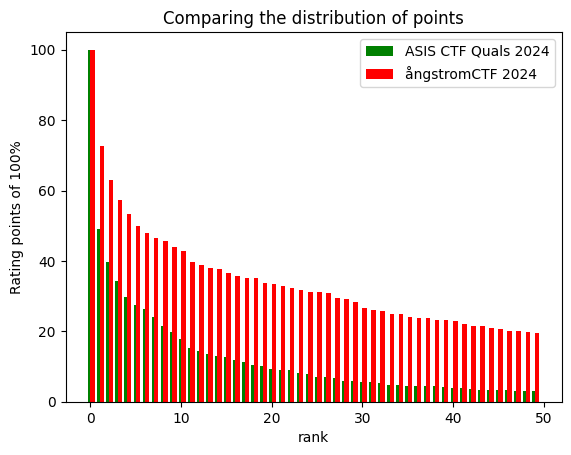

In [19]:
def getPoint(event_id, topN=50):
    r = requests.get(f"{EVENT_URL}/{event_id}", headers=CTFTIME_HEADERS)
    soup = BeautifulSoup(r.text, 'html.parser')
    title = soup.find('div', class_="page-header").text.strip()
    teams = soup.find_all('tr')[1:]
    points = [*map(lambda x:float(x.find_all('td')[-1].text), teams)]
    points = points[:topN] # top N
    maxPoint = points[0]
    points = [*map(lambda x: (x/maxPoint)*100, points)] # scale
    return title, points

t1, p1 = getPoint(2211) # ASIS CTF Quals 2024
t2, p2 = getPoint(2375) # ångstromCTF 2024

plt.bar(range(len(p1)), p1, width=0.5, color='g', label=t1)
plt.bar(range(len(p2)), p2, width=0.5, color='r', label=t2, align='edge')
plt.legend()
plt.xlabel('rank')
plt.ylabel('Rating points of 100%')
plt.title('Comparing the distribution of points')
plt.show()

---
# CTFTIME: Comparing Number of Events Organized vs. Points Earned

In [20]:
seen = set()
#start = int(datetime.fromisoformat("2005-12-01T00:00:00+00:00").timestamp())
start = int(datetime.fromisoformat("2017-01-01T00:00:00+00:00").timestamp())

team_data = pd.DataFrame(columns=["teamId", "teamName", "numberOfEvent", "pointEarned"])
team_data.set_index("teamId", inplace=True)

while True:
    events = requests.get(f'{API_URL}/events/?limit=1000&{start=}', headers=CTFTIME_HEADERS).json()
    if events[-1]['id'] in seen:
        break
    for event in events:
        seen.add( event['id'])
        points = event['weight']*2
        for org in event['organizers']:
            team_id, team_name = org['id'], org['name']
            if team_id in team_data.index:
                team_data.at[team_id, "numberOfEvent"] += 1
                team_data.at[team_id, "pointEarned"] += points
            else:
                team_data.loc[team_id] = [team_name, 1, points]
    start = int(datetime.fromisoformat(event['start']).timestamp())

print(f"{len(seen)} Events until {datetime.fromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')}")

1985 Events until 2025-12-27 17:30:00


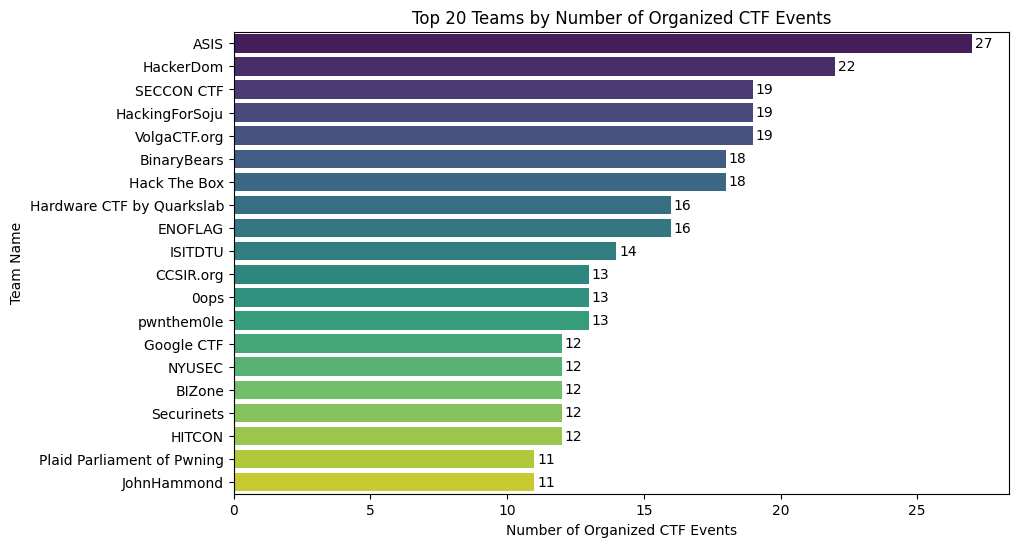

In [21]:
N = 20
top_teams = team_data.sort_values(by="numberOfEvent", ascending=False).head(N)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_teams["teamName"], x=top_teams["numberOfEvent"], palette='viridis', orient='h', hue=top_teams["teamName"])

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.ylabel("Team Name")
plt.xlabel("Number of Organized CTF Events")
plt.title(f"Top {N} Teams by Number of Organized CTF Events")
plt.show()

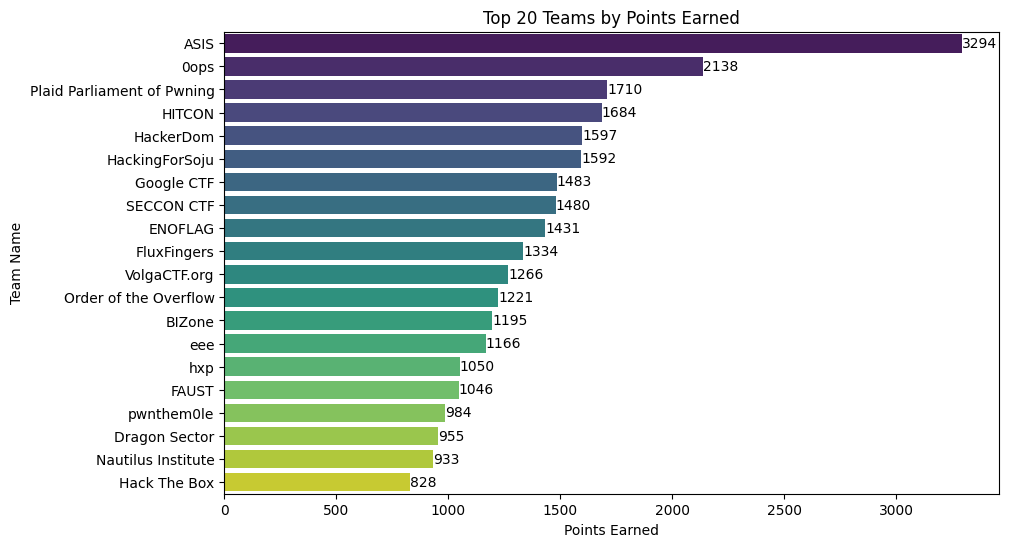

In [22]:
N = 20
top_teams_by_points = team_data.sort_values(by="pointEarned", ascending=False).head(N)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_teams_by_points["teamName"], x=top_teams_by_points["pointEarned"], palette='viridis', orient='h', hue=top_teams_by_points["teamName"])

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.ylabel("Team Name")
plt.xlabel("Points Earned")
plt.title(f"Top {N} Teams by Points Earned")
plt.show()

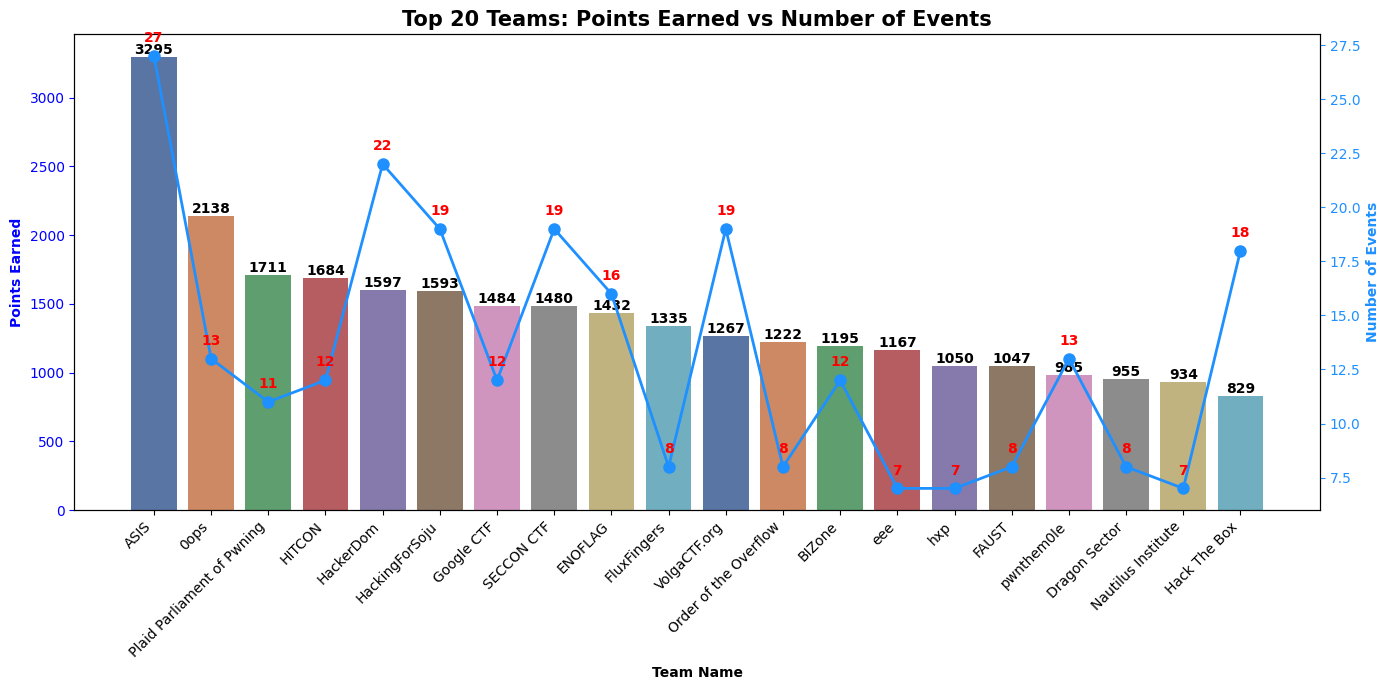

In [23]:
N = 20
top_teams_indexed = team_data.sort_values(by="pointEarned", ascending=False).head(N).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 7))

bars = sns.barplot(x="teamName", y="pointEarned", data=top_teams_indexed, 
                   hue="teamName", dodge=False, ax=ax1, 
                   palette="deep", legend=False)

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
for i, bar in enumerate(bars.patches):
    ax1.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{top_teams_indexed["pointEarned"].iloc[i]:.0f}', 
             ha='center', va='bottom', 
             fontweight='bold', color='black')

ax1.set_xlabel('Team Name', fontweight='bold')
ax1.set_ylabel('Points Earned', color='blue', fontweight='bold')
ax1.tick_params(axis='y', colors='blue')


ax2 = ax1.twinx()
line = ax2.plot(range(len(top_teams_indexed)), top_teams_indexed["numberOfEvent"], 
                color='#1E90FF', marker='o', 
                linewidth=2, markersize=8, 
                label='Number of Events')
for i, val in enumerate(top_teams_indexed["numberOfEvent"]):
    ax2.text(i, val+0.5, f'{val:.0f}', ha='center', va='bottom', fontweight='bold', color='red')
ax2.set_ylabel('Number of Events', color='#1E90FF', fontweight='bold')
ax2.tick_params(axis='y', colors='#1E90FF')

plt.title(f'Top {N} Teams: Points Earned vs Number of Events', fontsize=15, fontweight='bold')
plt.tight_layout()

plt.show()